In [53]:
import numpy as np
pi = np.pi
pi2i = pi*2j
from matplotlib import pyplot as plt
from time import time
from scipy.sparse.linalg import gmres

In [54]:
# some aux functions
def cplx2tuple(z):
    return np.real(z), np.imag(z)

# intro
I solved the interior 2d stokes problem on the circle in this jupyter notebook, which serves as a basis for further solution of this problem

In [55]:
# number of points
n = 64

# points on the interval [0,2*pi] as parametrization 
a = np.linspace(0,2*np.pi,n+1)[:-1]
# step-size, this can either be a single scalar in case of arc-length parametrization, or a sequence otherwise. 
h = 2*np.pi / n

# complex coordinates of points on the curve 
t = np.exp(a*1j)

# parametrization derivatives
dt_da = t*1j

# boundary conditions
v = np.zeros(n)
u = 1-(t.imag)**2
h2 = u
h1 = -v

# curvature, this is the curvature of unit circle. 
curvature = np.ones(n)

The kernels and BI eq can be greatly simplified in this specific case, compare to the original case in L. Greengard's paper. In this case, it is 

$$
K_1'(t_i,t_j) = \frac{-h}{\pi} \Im(\frac{d_j}{dt})\\
K_2'(t_i,t_j) = \frac{-h}{2\pi i} (\frac{-d_j}{\bar{dt}} + \frac{\bar{d_j}dt}{\bar{dt}^2}) 
$$ 
where $dt = t_i-t_j$, $d_j$ is the derivative of the parametrization. 

And in the limiting case of $i=j$, the kernels should be 

$$
K_1'(t_i,t_i) = \frac{h}{2\pi}\kappa_i |d_i| \\
K_2'(t_i,t_i) = \frac{-h}{2\pi} \kappa_i d_i^2/ |d_i|
$$

In [56]:
def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -h * np.imag(d/dt) / np.pi
        K2 = -h * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [57]:
K1, K2 = kernels(t,dt_da,h,curvature)



The integral equation is of the following form

$$
(I+K_1+K_2\mathfrak C) \omega = h
$$ where $\mathfrak C$ is a symbol for conjugation. 

This system can be discretized and solved using the Nystorm scheme. After that, we also need to separate it into real and complex parts to solve for it. 

$$
\begin{pmatrix}
I+\Re(K_1+K_2) & \Im(-K_1+K_2) \\
\Im(K_1 + K_2) & I+\Re(K_1-K_2)
\end{pmatrix}
\begin{pmatrix}
\Re \omega\\
\Im \omega
\end{pmatrix} = 
\begin{pmatrix}
\Re h\\
\Im h
\end{pmatrix}
$$

In [58]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real

In [59]:
rhs = np.concatenate((h1,h2))

In [60]:
omega,_ = gmres(A,rhs)
#omega = np.linalg.solve(A,rhs)

In [61]:
omega = omega[:n] + 1j*omega[n:]

In [62]:
def evaluation(z,omega,t,h,dt_da):
    
    d_t = dt_da*h
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW

# error analysis

Let's pretend that $5h$ rule is true in this case. since $5h = \frac{10\pi}{64} \approx 0.5$, so for $|z|\le 0.5$, there should be good convergence. 

# error on points $|z|\le 0.5$


In [63]:
grid_density = 1000
radius = 0.5
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
circle_grid = np.array([(x,y) for x in np.linspace(-1,1,grid_density) for y in np.linspace(-1,1,grid_density) if x**2 + y**2 <= radius**2])
circle_grid_X, circle_grid_Y = circle_grid.T
circle_grid_t = circle_grid_X + 1j*circle_grid_Y

circle_grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in circle_grid_t])
true_values = 1j*np.array([1-y**2 for x,y in circle_grid])

error = (np.abs(circle_grid_values - true_values))
relative_error = error/np.abs(true_values)

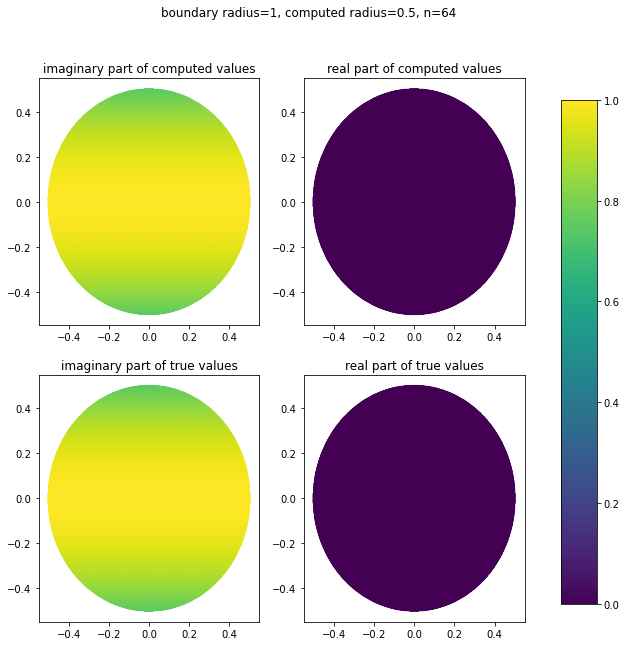

In [64]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

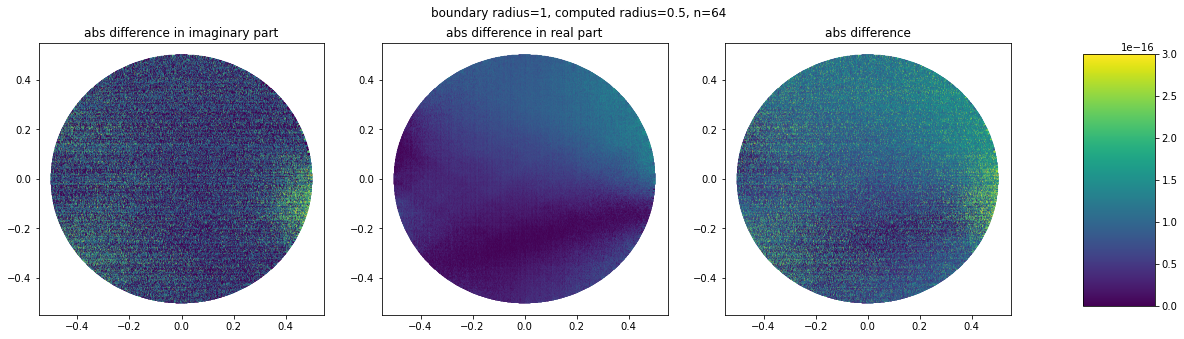

In [65]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).imag),s=1,vmin=0,vmax=3e-16)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).real),s=1,vmin=0,vmax=3e-16)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values)),s=1,vmin=0,vmax=3e-16)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

In [66]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 64 r= 0.5
error for velocity
max 4.662487371132648e-16 	mean 1.0332686666387285e-16
relative error for velocity: mean and max
max 4.662604169717261e-16 	mean 1.1086122597244595e-16


This is very close to machine precision, and agrees with the $5h$ rule. 

# error on points $|z|\le 0.8$

In [67]:
grid_density = 1000
radius = 0.8
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
circle_grid = np.array([(x,y) for x in np.linspace(-1,1,grid_density) for y in np.linspace(-1,1,grid_density) if x**2 + y**2 <= radius**2])
circle_grid_X, circle_grid_Y = circle_grid.T
circle_grid_t = circle_grid_X + 1j*circle_grid_Y

circle_grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in circle_grid_t])
true_values = 1j*np.array([1-y**2 for x,y in circle_grid])

error = (np.abs(circle_grid_values - true_values))
relative_error = error/np.abs(true_values)

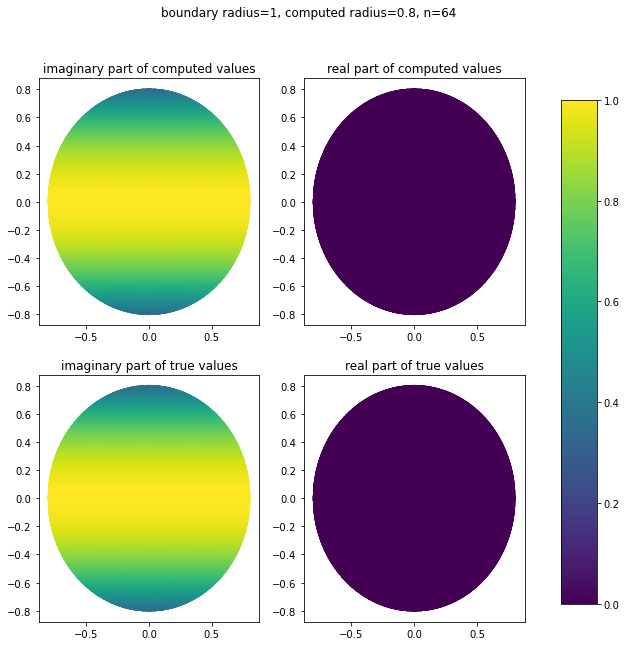

In [68]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

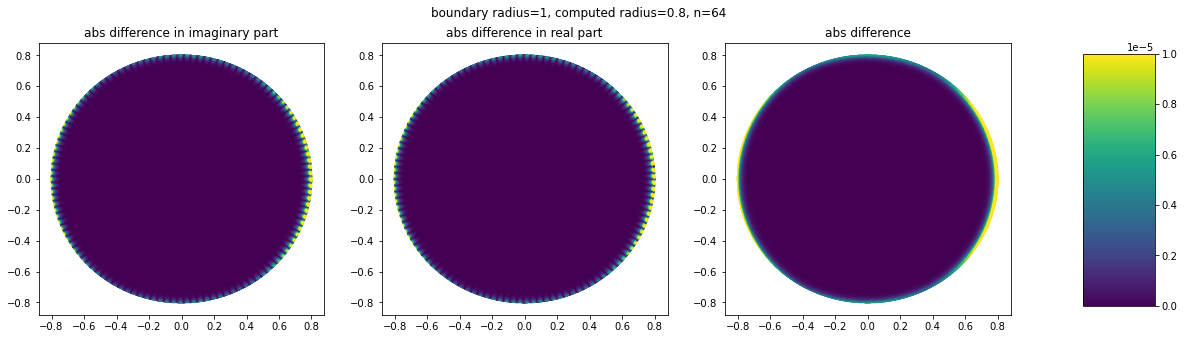

In [69]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).imag),s=1,vmin=0,vmax=1e-5)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).real),s=1,vmin=0,vmax=1e-5)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values)),s=1,vmin=0,vmax=1e-5)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

In [70]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 64 r= 0.8
error for velocity
max 1.865558279930776e-05 	mean 3.3232643494034156e-07
relative error for velocity: mean and max
max 1.869207026473825e-05 	mean 4.6224185485418497e-07


This is far from machine precision. 